# Analysis of results

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
import warnings
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve

# Suppress sklearn warnings for edge cases where y_true has only one class
warnings.filterwarnings('ignore', message='Only one class is present in y_true')
warnings.filterwarnings('ignore', message='No positive samples in y_true')
warnings.filterwarnings('ignore', message='No positive class found in y_true')

In [51]:
plt.rcParams['svg.fonttype'] = 'none'

In [52]:
# Path to results directory (relative to this notebook)
RESULTS_DIR = '../../results'

def extract_domain_id(seq_id):
    """Extract clean domain ID from various formats."""
    # Handle format: cath|4_4_0|107lA00/1-162 or cath|4_4_0|107lA00
    if '|' in seq_id:
        domain = seq_id.split('|')[-1]
        if '/' in domain:
            domain = domain.split('/')[0]
        return domain
    return seq_id

def create_pair_key(row, col1='seq1_id', col2='seq2_id'):
    """Create canonical pair key (sorted alphabetically)."""
    id1 = extract_domain_id(row[col1])
    id2 = extract_domain_id(row[col2])
    return ','.join(sorted([id1, id2]))

def load_method_csv(filepath, method_name, score_col='tm_score'):
    """Load a method's CSV and prepare for merging."""
    df = pd.read_csv(filepath)
    df['pair_key'] = df.apply(create_pair_key, axis=1)
    df = df[['pair_key', score_col]].rename(columns={score_col: method_name})
    # Remove duplicate pairs (keep first)
    df = df.drop_duplicates(subset='pair_key', keep='first')
    return df.set_index('pair_key')

# Load all method results
print("Loading CATH benchmark results...")

tmvec1 = load_method_csv(f'{RESULTS_DIR}/cath_tmvec1_similarities.csv', 'tmvec1')
print(f"  tmvec1: {len(tmvec1):,} pairs")

tmvec2 = load_method_csv(f'{RESULTS_DIR}/cath_tmvec2_similarities.csv', 'tmvec2')
print(f"  tmvec2: {len(tmvec2):,} pairs")

tmvec2_student = load_method_csv(f'{RESULTS_DIR}/cath_tmvec2_student_similarities.csv', 'tmvec2_student')
print(f"  tmvec2_student: {len(tmvec2_student):,} pairs")

tmalign = load_method_csv(f'{RESULTS_DIR}/cath_tmalign_similarities.csv', 'tmalign')
print(f"  tmalign: {len(tmalign):,} pairs")

foldseek = load_method_csv(f'{RESULTS_DIR}/cath_foldseek_similarities.csv', 'foldseek')
print(f"  foldseek: {len(foldseek):,} pairs")

# Merge all methods (use tmvec1 as base since it has all 499,500 pairs)
df = tmvec1.join([tmvec2, tmvec2_student, tmalign, foldseek], how='left')
print(f"\nMerged dataset: {len(df):,} pairs")

# Add CATH hierarchy labels (placeholder - set all to 0 for now)
# Real hierarchy labels would need CATH domain classification data
df['class'] = 0
df['architecture'] = 0
df['topology'] = 0
df['superfamily'] = 0

df.index.name = 'seq_ids'
df

Loading CATH benchmark results...
  tmvec1: 499,500 pairs
  tmvec2: 499,500 pairs
  tmvec2_student: 499,500 pairs
  tmalign: 491,536 pairs
  foldseek: 78,646 pairs

Merged dataset: 499,500 pairs


,tmvec1,tmvec2,tmvec2_student,tmalign,foldseek,class,architecture,topology,superfamily
seq_ids,,,,,,,,,
"107lA00,108lA00",0.999900,0.986187,0.974749,0.99929,1.006,0,0,0,0
"107lA00,109lA00",0.999929,0.991714,0.982852,0.99945,1.006,0,0,0,0
"107lA00,110lA00",0.999920,0.987399,0.979588,0.99947,1.006,0,0,0,0
"107lA00,111lA00",0.999960,0.996667,0.987025,0.99929,1.006,0,0,0,0
"107lA00,112lA00",0.999958,0.988583,0.985575,0.99892,1.005,0,0,0,0
...,...,...,...,...,...,...,...,...,...
"1b7jA00,1b7lA00",0.480856,0.353141,0.279840,0.26842,NaN,0,0,0,0
"1b7jA00,1b7mA00",0.490731,0.345178,0.276629,0.26723,NaN,0,0,0,0
"1b7kA00,1b7lA00",0.478964,0.334604,0.259384,0.27057,NaN,0,0,0,0


In [53]:
bins = [0.0, 0.25, 0.5, 0.75, 1.0]
df['bin'] = pd.cut(df['tmalign'], bins=bins, right=True)

In [54]:
methods = ['tmvec1', 'tmvec2', 'tmvec2_student', 'tmalign', 'foldseek']
names = ['TM-Vec 1', 'TM-Vec 2', 'TM-Vec 2 Student', 'TM-align', 'Foldseek']

In [55]:
levels = ['class', 'architecture', 'topology', 'superfamily']

Correlation

In [56]:
df_score = df[['tmvec1', 'tmvec2', 'tmvec2_student', 'tmalign']].dropna(how='any')
df_score

,tmvec1,tmvec2,tmvec2_student,tmalign
seq_ids,,,,
"107lA00,108lA00",0.999900,0.986187,0.974749,0.99929
"107lA00,109lA00",0.999929,0.991714,0.982852,0.99945
"107lA00,110lA00",0.999920,0.987399,0.979588,0.99947
"107lA00,111lA00",0.999960,0.996667,0.987025,0.99929
"107lA00,112lA00",0.999958,0.988583,0.985575,0.99892
...,...,...,...,...
"1b7jA00,1b7lA00",0.480856,0.353141,0.279840,0.26842
"1b7jA00,1b7mA00",0.490731,0.345178,0.276629,0.26723
"1b7kA00,1b7lA00",0.478964,0.334604,0.259384,0.27057


In [57]:
score_bins = np.arange(0, 1.015, 0.015)

In [58]:
text = 'Pearson R = {:.3f}\np-value = {:.2e}\nMAE = {:.3f}\nRMSE = {:.3f}'

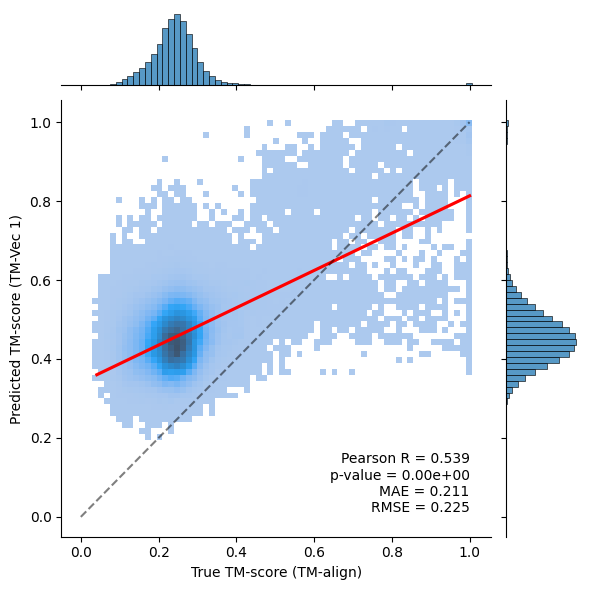

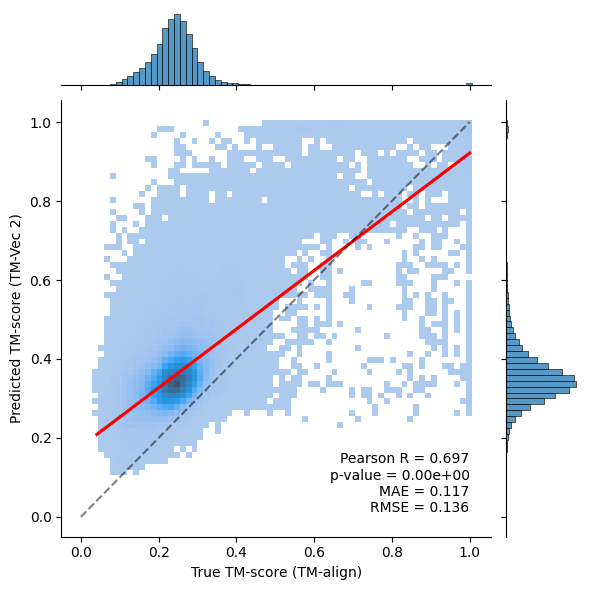

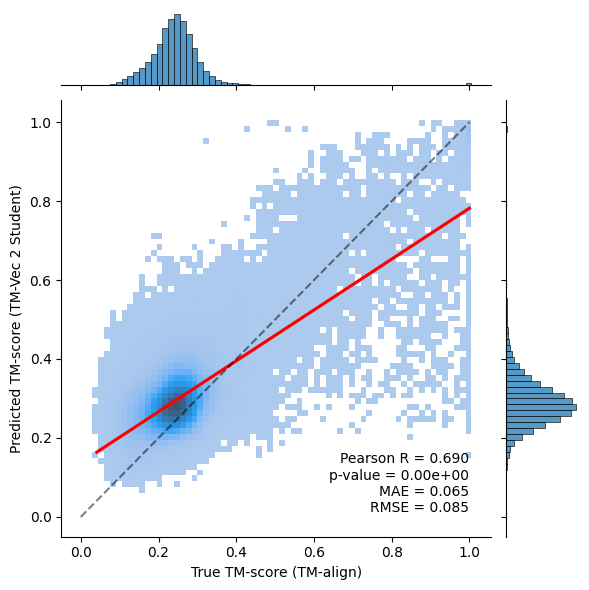

In [59]:
x = df_score['tmalign'].to_numpy()
for i in range(3):  # tmvec1, tmvec2, tmvec2_student
    method, name = methods[i], names[i]

    # Statistics
    y = df_score[method].to_numpy()
    r, p = pearsonr(x, y)
    diff = x - y
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff ** 2))

    # Correlation plot
    g = sns.JointGrid(data=df_score, x='tmalign', y=method, height=6)
    g.plot_joint(sns.histplot, bins=(score_bins, score_bins))
    g.plot_joint(sns.regplot, scatter=False, color='red')
    g.plot_marginals(sns.histplot, bins=score_bins)

    ax = g.ax_joint
    ax.plot((0, 1), (0, 1), 'k--', alpha=0.5)
    ax.text(0.95, 0.05, text.format(r, p, mae, rmse), transform=ax.transAxes, ha='right', va='bottom')
    ax.set_xlabel('True TM-score (TM-align)')
    ax.set_ylabel(f'Predicted TM-score ({name})')

    g.savefig(f'plots/{method}.svg')

Distribution

In [60]:
df_melt = df_score.melt(var_name='Method', value_name='TM-score')

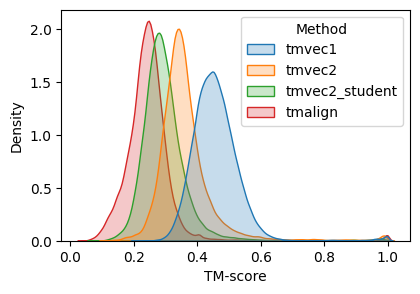

In [61]:
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.kdeplot(data=df_melt, x='TM-score', hue='Method', fill=True, alpha=0.25, ax=ax)
fig.savefig('plots/distribution.svg')

Errors

In [62]:
df_err = df_score[['tmvec1', 'tmvec2', 'tmvec2_student']].sub(df['tmalign'], axis=0).abs()

In [63]:
df_err_melt = df_err.melt(var_name='method', value_name='error')

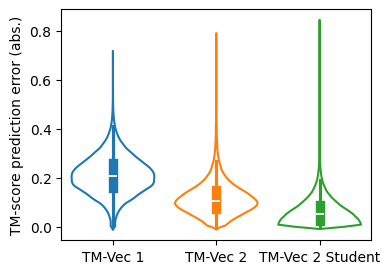

In [64]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.violinplot(data=df_err_melt, x='method', y='error', hue='method', order=methods[:3], fill=False, ax=ax)
ax.set_ylabel('TM-score prediction error (abs.)')
ax.set_xlabel(None)
ax.set_xticks(range(3), names[:3])
fig.savefig('plots/tmscore_error.svg')

In [65]:
df_err['bin'] = df['bin']

In [66]:
df_err_bin_melt = df_err.melt(id_vars='bin', value_vars=methods[:3], var_name='method', value_name='error')
df_err_bin_melt

,bin,method,error
0,"(0.75, 1.0]",tmvec1,0.000610
1,"(0.75, 1.0]",tmvec1,0.000479
2,"(0.75, 1.0]",tmvec1,0.000450
3,"(0.75, 1.0]",tmvec1,0.000670
4,"(0.75, 1.0]",tmvec1,0.001038
...,...,...,...
1498495,"(0.25, 0.5]",tmvec2_student,0.011420
1498496,"(0.25, 0.5]",tmvec2_student,0.009399
1498497,"(0.25, 0.5]",tmvec2_student,0.011186
1498498,"(0.25, 0.5]",tmvec2_student,0.012485


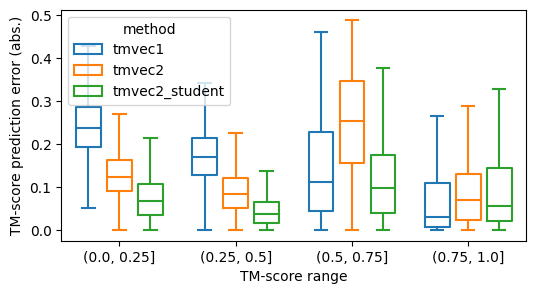

In [67]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(data=df_err_bin_melt, x='bin', y='error', hue='method', hue_order=methods[:3], fill=False, showfliers=False, gap=0.2)
ax.set_xlabel('TM-score range')
ax.set_ylabel('TM-score prediction error (abs.)')
fig.savefig('plots/tmscore_error_bin.svg')

Accuracy (vs. TM-align)

In [68]:
df_score = df.drop(columns='foldseek').dropna(how='any')
print(df_score.shape[0])

491536


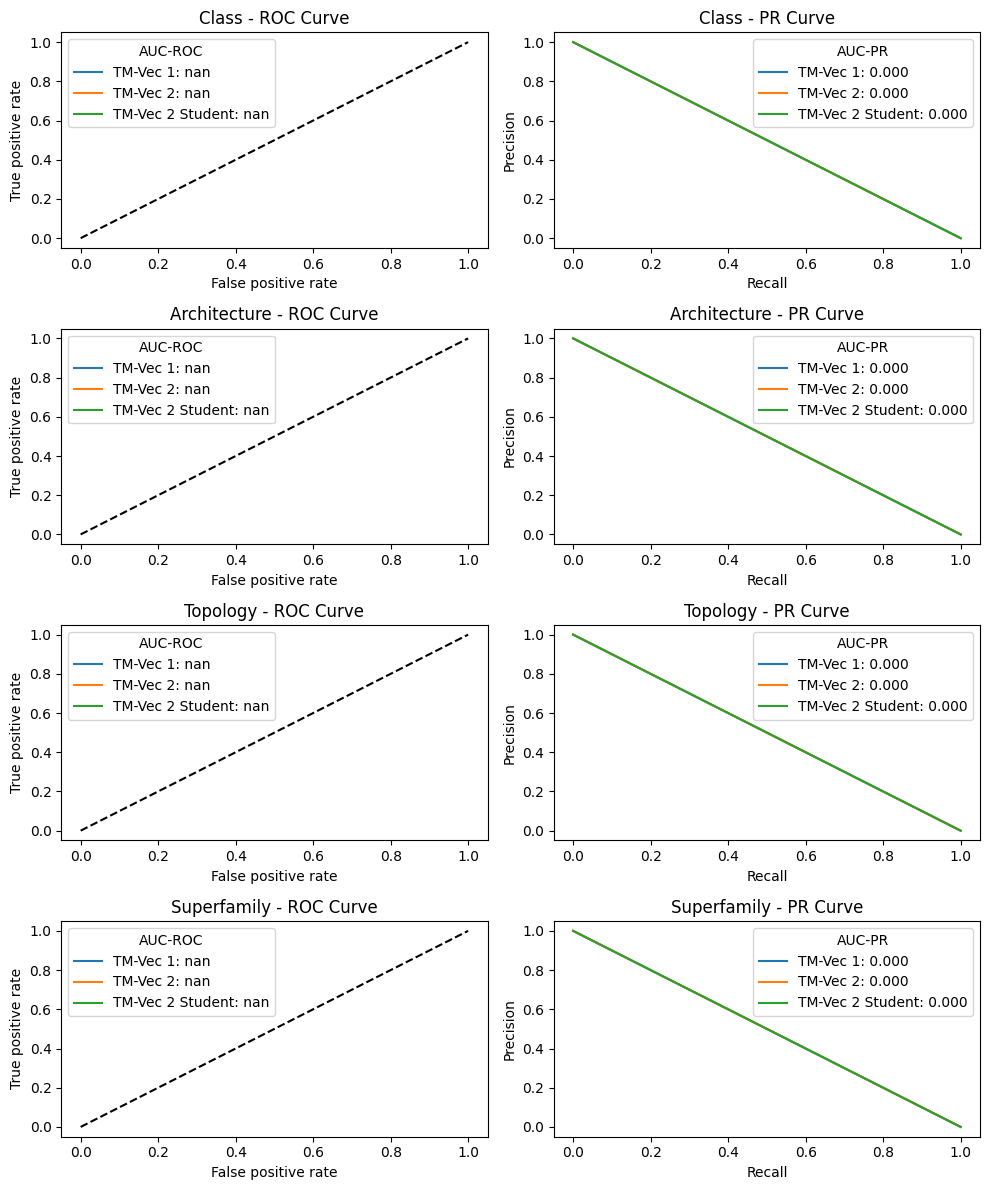

In [69]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i, level in enumerate(levels):
    y_true = df_score[level].to_numpy()

    ax = axes[i, 0]
    for method, name in zip(methods[:3], names[:3]):  # tmvec1, tmvec2, tmvec2_student
        y_score = df_score[method].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{name}: {auroc:.3f}')
    ax.legend(title='AUC-ROC')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(f'{level.capitalize()} - ROC Curve')

    ax = axes[i, 1]
    for method, name in zip(methods[:3], names[:3]):  # tmvec1, tmvec2, tmvec2_student
        y_score = df_score[method].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{name}: {aupr:.3f}')
    ax.legend(title='AUC-PR')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{level.capitalize()} - PR Curve')
fig.tight_layout()
fig.savefig('plots/tmscore_accuracy.svg')

Accuracy (vs. Foldseek)

In [70]:
df_fold = df.drop(columns='tmalign').dropna(how='any')
print(df_fold.shape[0])

77725


In [71]:
values = df_fold['foldseek'].to_numpy()
values[values == 0] = values[values > 0].min() * 0.1
df_fold['foldseek'] = -np.log10(values)

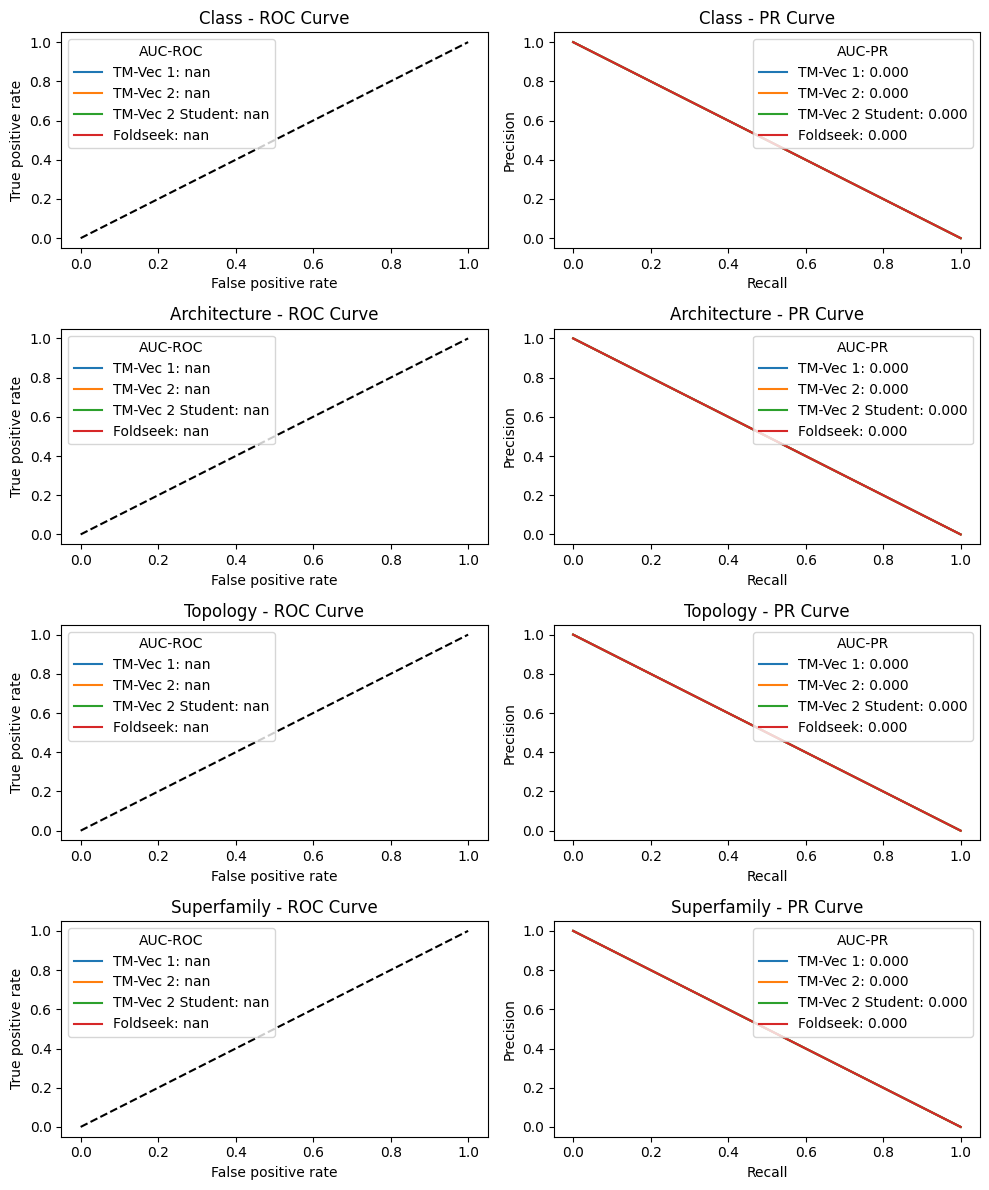

In [72]:
# Compare foldseek with tmvec methods (indices 0, 1, 2 = tmvec1, tmvec2, tmvec2_student; 4 = foldseek)
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
for i, level in enumerate(levels):
    y_true = df_fold[level].to_numpy()

    ax = axes[i, 0]
    for j in (0, 1, 2, 4):  # tmvec1, tmvec2, tmvec2_student, foldseek
        y_score = df_fold[methods[j]].to_numpy()
        auroc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label=f'{names[j]}: {auroc:.3f}')
    ax.legend(title='AUC-ROC')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(f'{level.capitalize()} - ROC Curve')

    ax = axes[i, 1]
    for j in (0, 1, 2, 4):  # tmvec1, tmvec2, tmvec2_student, foldseek
        y_score = df_fold[methods[j]].to_numpy()
        aupr = average_precision_score(y_true, y_score)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ax.plot(recall, precision, label=f'{names[j]}: {aupr:.3f}')
    ax.legend(title='AUC-PR')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{level.capitalize()} - PR Curve')
fig.tight_layout()
fig.savefig('plots/foldseek_accuracy.svg')

In [73]:
print("Done!")

Done!
